# Installing / Importing Libraries

In [35]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,5)
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.stattools import adfuller,kpss
import seaborn as sns
import holidays
import datetime
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error

from lazypredict.Supervised import LazyRegressor
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV

## Data conversion

This section of the procedure implements a function that can convert a time series into supervised learning data.

In [80]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
Daily_data = pd.read_csv(path+'/Daily_data.csv', sep=',', header=0, parse_dates=True)
Daily_data = Daily_data.drop(['Inquiries_Stat'],axis=1)
Daily_data.set_index('date', inplace = True)
Daily_data = Daily_data.loc[:'2022-09-31']
Daily_data.tail()

,Inquiries_NonStat
date,
2022-09-26,13039.0
2022-09-27,11598.0
2022-09-28,11886.0
2022-09-29,11772.0
2022-09-30,10669.0


Past 2 years data from 2020 Jan to 2022 Sept

<AxesSubplot: xlabel='date'>

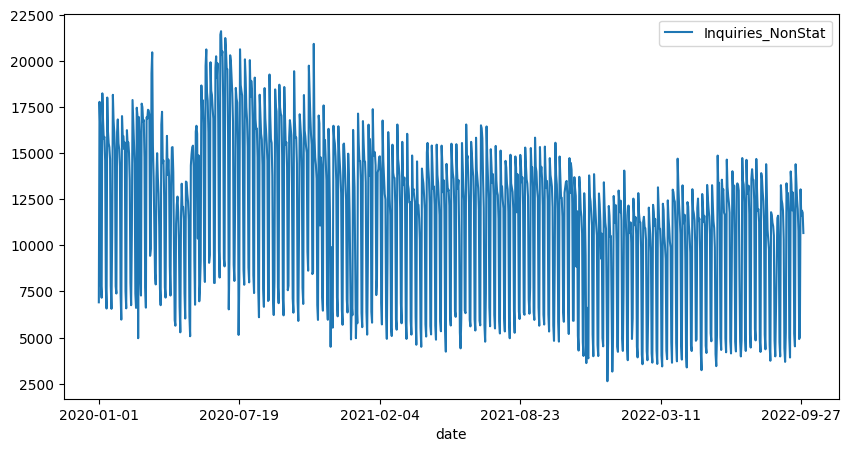

In [65]:
Daily_data.loc['2020-01-01':'2022-09-31'].plot()

### Check for Stationairty

In [199]:
filterwarnings("ignore")
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        if(dfoutput['Test Statistic'] <= dfoutput['Critical Value (%s)'%key] ):
            print('Stationary')
        else:
            print('Non-Stationary')

    print ()
    print (dfoutput)
    print ()
    
adf_test(Daily_data['Inquiries_NonStat'].dropna()) 
# Test Statistics > Critical value (Should be TS <= CV to reject)
# p-value  0.05 (Should be p-value <= significance level to reject)

# Failed to Reject Null hypothesis -- > Non-Stationary data 

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
        if(kpss_output['Test Statistic'] > kpss_output['Critical Value (%s)'%key] ):
            print('Non-Stationary')
        else:
            print('Stationary')
            
    print ()
    print (kpss_output)
    print ()
kpss_test(Daily_data['Inquiries_NonStat'].dropna())
# Test Statistics > Critical value (Should be TS > CV to reject)
# p-value < 0.05 (Should be p-value > significance level to reject)
# Rejected Null hypothesis -- > Non stationary data 

Results of Dickey-Fuller Test:
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic                   -2.035716
p-value                           0.271136
#Lags Used                       26.000000
Number of Observations Used    2072.000000
Critical Value (1%)              -3.433510
Critical Value (5%)              -2.862936
Critical Value (10%)             -2.567513
dtype: float64

Results of KPSS Test:
Non-Stationary
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic           10.091257
p-value                   0.010000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64



## Feature Engineering

### Seasons

In [111]:
# function to create seasons for dataframe
def seasons(df):
    '''
    Function to create new features for seasons based on months
    Args: df = dataframe
    Returns: df = dataframe
    '''
    
    # create a season features
    df.loc[(df.index.month >=3) & (df.index.month <=5), 'season_spring'] = 1
    df.loc[(df.index.month >=6) & (df.index.month <=8), 'season_summer'] = 1
    df.loc[(df.index.month >=9) & (df.index.month <=11), 'season_fall'] = 1
    df.loc[((df.index.month >=1) & (df.index.month <=2)) | (df.index.month ==12), 'season_winter'] = 1

    return df

In [112]:
Daily_data.reset_index(inplace = True)
Daily_data['date'] = pd.to_datetime(Daily_data['date'])
Daily_data.set_index('date', inplace = True)

Daily_data = seasons(Daily_data)

In [113]:
Daily_data

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter
date,,,,,
2017-01-01,7574.0,0,0,0,1
2017-01-02,13189.0,0,0,0,1
2017-01-03,24678.0,0,0,0,1
2017-01-04,23380.0,0,0,0,1
2017-01-05,22809.0,0,0,0,1
...,...,...,...,...,...
2022-09-26,13039.0,0,0,1,0
2022-09-27,11598.0,0,0,1,0
2022-09-28,11886.0,0,0,1,0


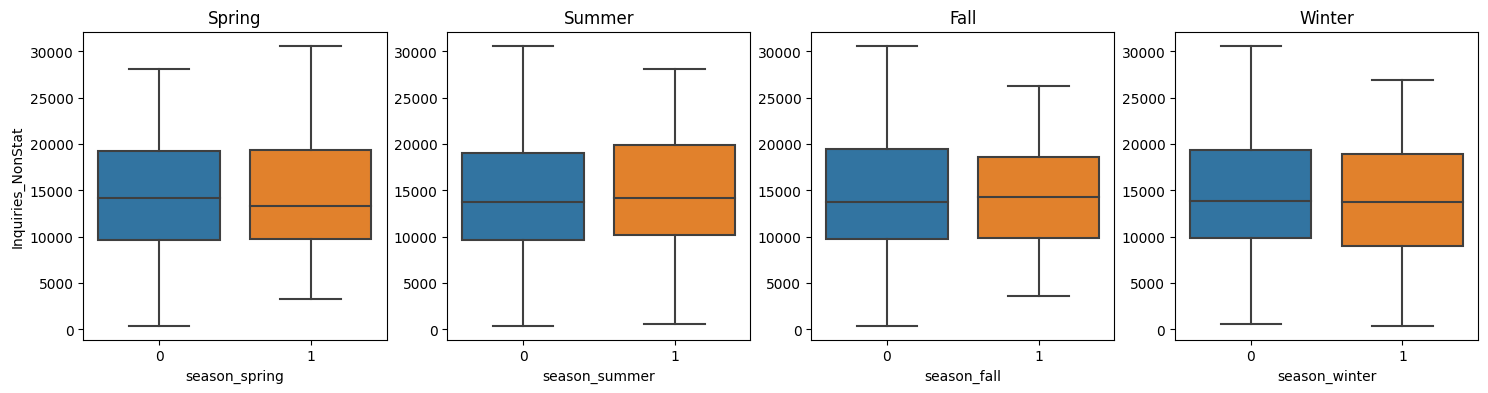

In [142]:
# Create the boxplots for seasons
# Create the figure and axis objects
fig, ax = plt.subplots(1, 4, figsize=(18, 4))
# Create the first boxplot
sns.boxplot(x='season_spring', y='Inquiries_NonStat', data=Daily_data, ax=ax[0])
ax[0].set_title('Spring')

# Create the second boxplot
sns.boxplot(x='season_summer', y='Inquiries_NonStat', data=Daily_data, ax=ax[1])
ax[1].set_title('Summer')
ax[1].set_ylabel('')

# Create the third boxplot
sns.boxplot(x='season_fall', y='Inquiries_NonStat', data=Daily_data, ax=ax[2])
ax[2].set_title('Fall')
ax[2].set_ylabel('')
# Create the fourth boxplot
sns.boxplot(x='season_winter', y='Inquiries_NonStat', data=Daily_data, ax=ax[3])
ax[3].set_title('Winter')
ax[3].set_ylabel('')
# Show the plot
plt.show()


There is not much connection between the number of inquiries and season of the year. 

### Holidays

In [144]:
df=Daily_data
df = df.reset_index()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['date'])
# Create a DataFrame of holidays

nyc_holidays = holidays.US(state='NY', years=[2017,2018,2019,2020,2021,2022])
holidays_df = pd.DataFrame(nyc_holidays.items(), columns = ['date','holiday'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])
holidays_df = holidays_df.set_index(['date'])

# Join the holidays DataFrame with the original DataFrame
df = df.join(holidays_df, on='date')
df = df.replace(to_replace=r'[^0]', value=1, regex=True).fillna(0)
Daily_data = df

<AxesSubplot: xlabel='holiday', ylabel='Inquiries_NonStat'>

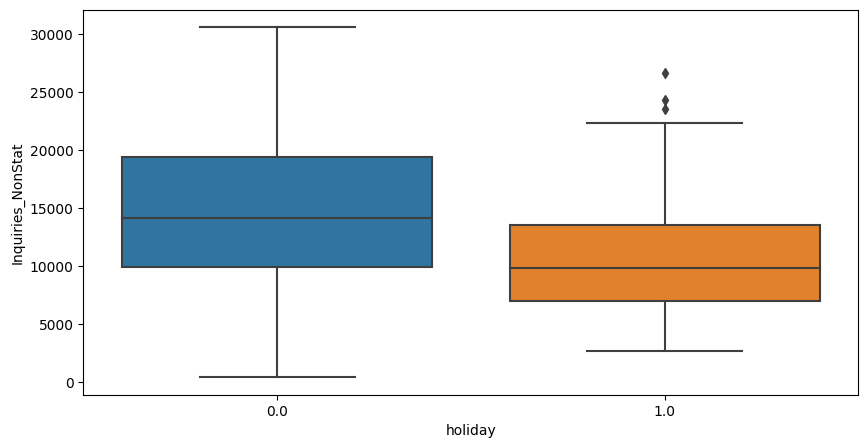

In [149]:
sns.boxplot(x='holiday', y='Inquiries_NonStat', data=Daily_data)
#ax.set_title('Holiday')

For the holiday feature, we can clearly see that there is on average a higher inquiries on days that are not holidays. This feature will be used in the final model to predict the overall demand.

In [151]:
from scipy.stats import kruskal, pearsonr, randint, uniform, chi2_contingency, boxcox
# Correlation between holiday feature and the number of inquiries per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(Daily_data['holiday'], Daily_data['Inquiries_NonStat'])

KruskalResult(statistic=3538.5041725436877, pvalue=0.0)

### Weekdays

In [132]:
### create new feature weekday
Daily_data['weekday'] = Daily_data.index.weekday

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,weekday
date,,,,,,
2017-01-01,7574.0,0,0,0,1,6
2017-01-02,13189.0,0,0,0,1,0
2017-01-03,24678.0,0,0,0,1,1
2017-01-04,23380.0,0,0,0,1,2
2017-01-05,22809.0,0,0,0,1,3
...,...,...,...,...,...,...
2022-09-26,13039.0,0,0,1,0,0
2022-09-27,11598.0,0,0,1,0,1
2022-09-28,11886.0,0,0,1,0,2


In [133]:
### one hot encode the feature weekday
weekday_dummies = pd.get_dummies(Daily_data['weekday'], prefix='weekday', drop_first=True)
Daily_data = Daily_data.join(weekday_dummies, how='left')
Daily_data.head()

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,weekday,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,
2017-01-01,7574.0,0,0,0,1,6,0,0,0,0,0,1
2017-01-02,13189.0,0,0,0,1,0,0,0,0,0,0,0
2017-01-03,24678.0,0,0,0,1,1,1,0,0,0,0,0
2017-01-04,23380.0,0,0,0,1,2,0,1,0,0,0,0
2017-01-05,22809.0,0,0,0,1,3,0,0,1,0,0,0


In [156]:
### create new feature working_day
Daily_data['working_day'] = Daily_data['weekday'].apply(lambda x: 0 if x >= 5 else 1)
Daily_data['working_day'] = Daily_data[['holiday', 'working_day']].apply(
    lambda x: 0 if x['holiday'] == 1 else x['working_day'], axis=1)
Daily_data

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,weekday,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,working_day,holiday
date,,,,,,,,,,,,,,
2017-01-01,7574.0,0,0,0,1,6,0,0,0,0,0,1,0.0,1.0
2017-01-02,13189.0,0,0,0,1,0,0,0,0,0,0,0,0.0,1.0
2017-01-03,24678.0,0,0,0,1,1,1,0,0,0,0,0,1.0,0.0
2017-01-04,23380.0,0,0,0,1,2,0,1,0,0,0,0,1.0,0.0
2017-01-05,22809.0,0,0,0,1,3,0,0,1,0,0,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,13039.0,0,0,1,0,0,0,0,0,0,0,0,1.0,0.0
2022-09-27,11598.0,0,0,1,0,1,1,0,0,0,0,0,1.0,0.0
2022-09-28,11886.0,0,0,1,0,2,0,1,0,0,0,0,1.0,0.0


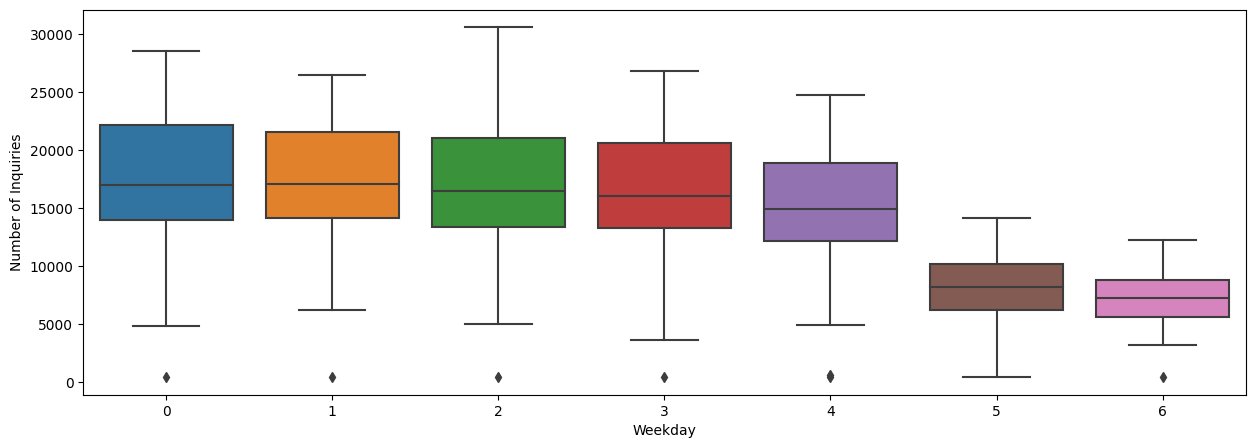

In [152]:
# plotting the customer statistics in form of a boxplot for the weekday feature
plt.figure(figsize = [15, 5])
sns.boxplot(data = Daily_data, x = 'weekday', y = 'Inquiries_NonStat')
plt.xlabel('Weekday')
plt.ylabel('Number of Inquiries');

In [153]:
# Correlation between weekday feature and the number of inquiries per day
# using Pearson's correlation coefficient because I'm assuming that weekday can be 
# considered a continuous variable
pearsonr(Daily_data['weekday'], Daily_data['Inquiries_NonStat'])

PearsonRResult(statistic=-0.6424858015009073, pvalue=1.0337213475969245e-244)

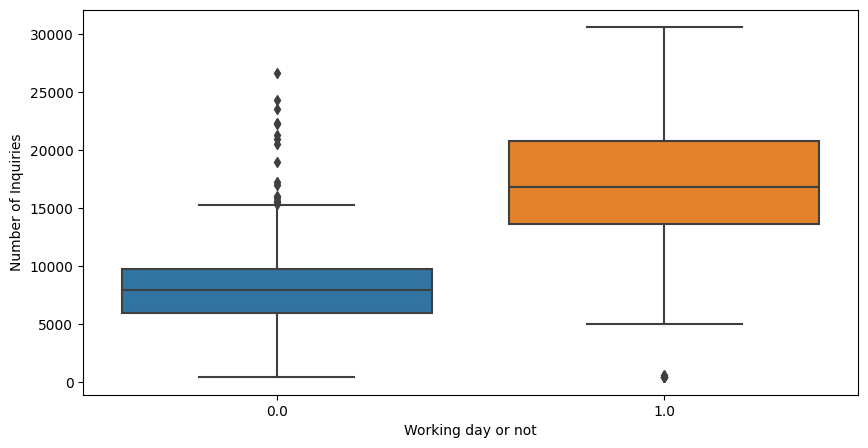

In [158]:
# plotting workday feature in boxplot against the count of customers
sns.boxplot(data = Daily_data, x = 'working_day', y = 'Inquiries_NonStat')
plt.xlabel('Working day or not')
plt.ylabel('Number of Inquiries');

In [159]:
# Correlation between working_day feature and the number of Inquiries per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(Daily_data['working_day'], Daily_data['Inquiries_NonStat'])

KruskalResult(statistic=3290.489700761312, pvalue=0.0)

In [161]:
Daily_data.head(2)

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,weekday,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,working_day,holiday
date,,,,,,,,,,,,,,
2017-01-01,7574.0,0,0,0,1,6,0,0,0,0,0,1,0.0,1.0
2017-01-02,13189.0,0,0,0,1,0,0,0,0,0,0,0,0.0,1.0


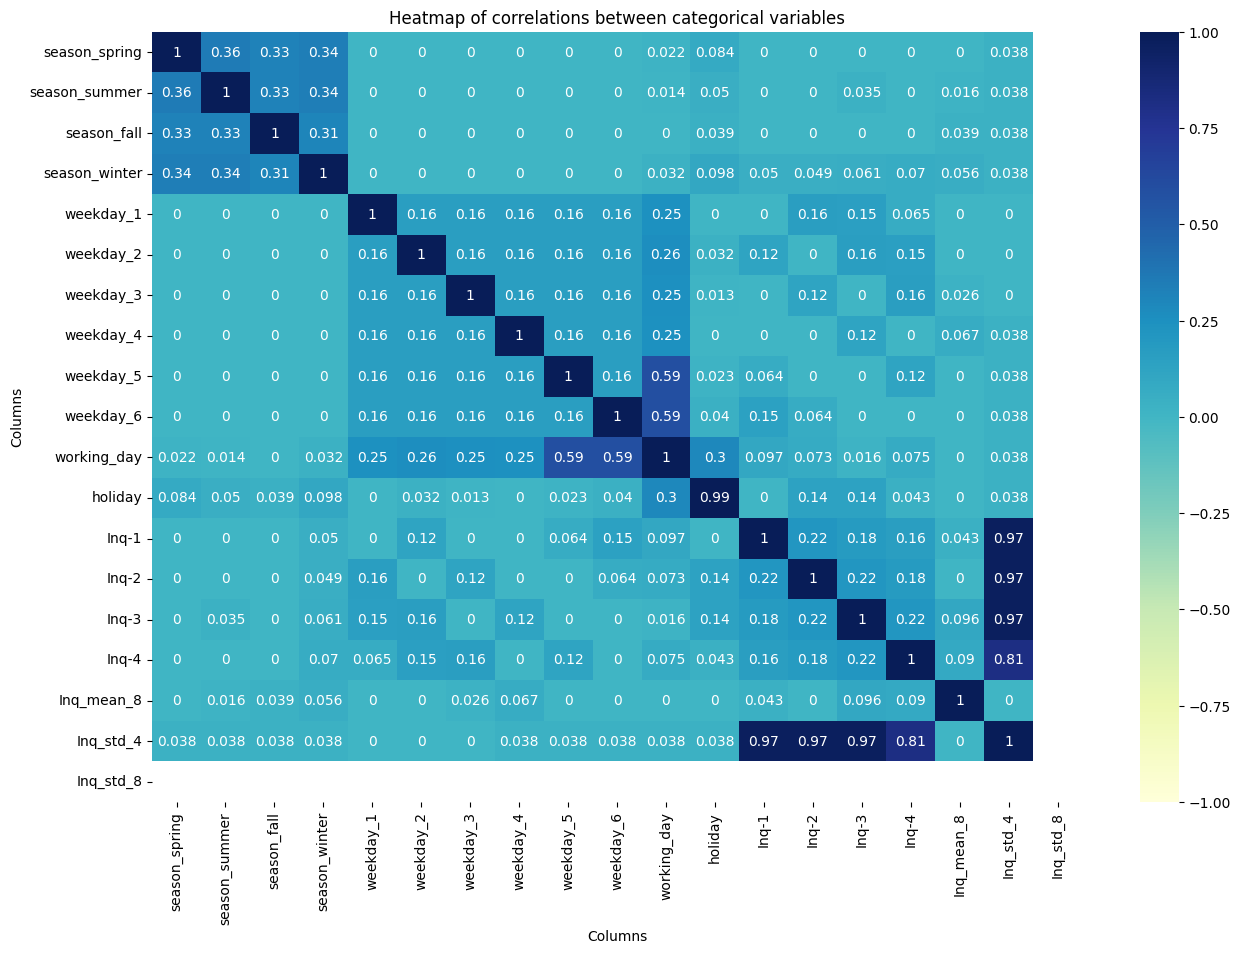

In [254]:
# drop any non-categorical variables
Daily_data_corr_cat = Daily_data.drop(columns=['weekday', 'Inquiries_NonStat'], axis=1)


# this code snippet was taken from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


# create correlation matrix with cramer's V coefficients
corr_matrix = pd.DataFrame(data = None, index=np.arange(len(Daily_data_corr_cat.columns)), 
                            columns=Daily_data_corr_cat.columns)

for col in Daily_data_corr_cat.columns:
    count = 0
    for val in Daily_data_corr_cat.columns:
        corr_cat = cramers_v(Daily_data_corr_cat[col], Daily_data_corr_cat[val])
        corr_matrix[col][count] = corr_cat
        count += 1
    corr_matrix = corr_matrix.astype('float')


# add an index to the dataframe
corr_matrix['columns'] = Daily_data_corr_cat.columns
corr_matrix.set_index('columns', inplace=True)

# plot a heatmap for correlations between categorical variables
plt.figure(figsize=[15,10])
sns.heatmap(corr_matrix, annot=True,
          vmin=-1, vmax=1, center=0,
          fmt='.2g', cmap='YlGnBu')
plt.title('Heatmap of correlations between categorical variables')
plt.xlabel('Columns')
plt.ylabel('Columns');

### PACF to determine optimal lag for total_cust target label

Details on the process can be found here and here. We want to avoid using variables with multicolinearity and thus, we do not want to use too many lag variables.

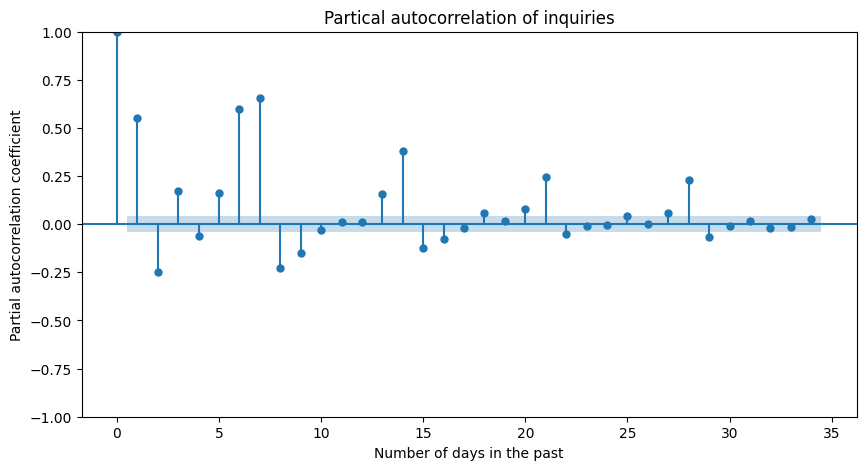

In [163]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# plotting the partial autocorrelation for target
plot_pacf(Daily_data['Inquiries_NonStat'], title='Partical autocorrelation of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

Rolling mean of 9 days from the above plot

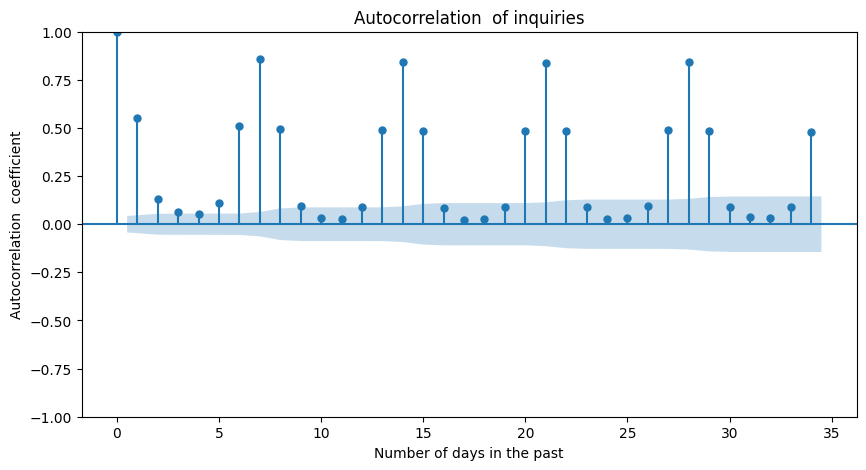

In [164]:
plot_acf(Daily_data['Inquiries_NonStat'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

Lag 1,6,7,8

In [165]:
# get list for all correlations between a feature and total_cust with different rolling means

def best_window(x, y, max_window):
    corr_temp_cust = []
    for i in range(1, max_window):
        roll_val = list(x.rolling(i).mean()[i-1:-1])
        total_cust_ti = list(y[i:])
        corr, p_val = pearsonr(total_cust_ti, roll_val)
        corr_temp_cust.append(corr)
    # get the optimal window size for rolling mean between a feature and total_cust
    max_val = np.argmax(corr_temp_cust)
    min_val = np.argmin(corr_temp_cust)
    opt_corr_min = corr_temp_cust[min_val]
    opt_corr_max = corr_temp_cust[max_val]
    
    results = {max_val+1: opt_corr_max, min_val+1: opt_corr_min}
    
    return results

# get list for all correlations between a feature and total_cust with different rolling standard deviations

def best_window_std(x, y, max_window):
    corr_temp_cust = []
    for i in range(2, max_window):
        roll_val = list(x.rolling(i).std()[i-1:-1])
        total_cust_ti = list(y[i:])
        corr, p_val = pearsonr(total_cust_ti, roll_val)
        corr_temp_cust.append(corr)
    # get the optimal window size for rolling std between a feature and total_cust
    max_val = np.argmax(corr_temp_cust)
    min_val = np.argmin(corr_temp_cust)
    opt_corr_min = corr_temp_cust[min_val]
    opt_corr_max = corr_temp_cust[max_val]
    
    results = {max_val+1: opt_corr_max, min_val+1: opt_corr_min}
    
    return results

In [186]:
# get the optimal window for rolling std for Inquiries_NonStat
print(best_window_std(Daily_data['Inquiries_NonStat'], Daily_data['Inquiries_NonStat'], 30))

# get the correlation for window size determined by Inquiries_NonStat
cust_mean = Daily_data['Inquiries_NonStat'].rolling(9).std()[8:-1]
pearsonr(cust_mean, Daily_data['Inquiries_NonStat'][9:])

{4: 0.70887593139994, 1: 0.025517592107480194}


PearsonRResult(statistic=0.51058850055871, pvalue=3.81771432928067e-139)

In [177]:
# get the optimal window for rolling std for Inquiries_NonStat
print(best_window(Daily_data['Inquiries_NonStat'], Daily_data['Inquiries_NonStat'], 30))

# get the correlation for window size determined by Inquiries_NonStat
cust_mean = Daily_data['Inquiries_NonStat'].rolling(9).mean()[8:-1]
pearsonr(cust_mean, Daily_data['Inquiries_NonStat'][9:])

{8: 0.5841399213922005, 5: 0.28228744478784407}


PearsonRResult(statistic=0.5319204472576591, pvalue=5.199876289505205e-153)

### Adding Mean of 9 days and std of 4 days rolling window size

In [228]:
# Calculate the mean and standard deviation of a rolling window size 8
Daily_data['Inq_mean_9'] = Daily_data['Inquiries_NonStat'].rolling(window=9).mean()
Daily_data['Inq_std_4'] = Daily_data['Inquiries_NonStat'].rolling(window=4).std()
Daily_data['Inq_std_8'] = Daily_data['Inquiries_NonStat'].rolling(window=8).std()

In [261]:
# add the value from t-1
Daily_data['Inq-1'] = Daily_data['Inquiries_NonStat'].shift(1)
Daily_data['Inq-2'] = Daily_data['Inquiries_NonStat'].shift(2)
Daily_data['Inq-3'] = Daily_data['Inquiries_NonStat'].shift(3)
Daily_data['Inq-4'] = Daily_data['Inquiries_NonStat'].shift(4)
Daily_data.head(2)

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,weekday,weekday_1,weekday_2,weekday_3,weekday_4,...,weekday_6,working_day,holiday,Inq-1,Inq-2,Inq-3,Inq-4,Inq_mean_8,Inq_std_4,Inq_std_8
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,7574.0,0,0,0,1,6,0,0,0,0,...,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,13189.0,0,0,0,1,0,0,0,0,0,...,0,0.0,1.0,7574.0,NaN,NaN,NaN,NaN,NaN,NaN


In [257]:
Daily_data.head(2)

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,weekday,weekday_1,weekday_2,weekday_3,weekday_4,...,weekday_6,working_day,holiday,Inq-1,Inq-2,Inq-3,Inq-4,Inq_mean_8,Inq_std_4,Inq_std_8
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,7574.0,0,0,0,1,6,0,0,0,0,...,1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,13189.0,0,0,0,1,0,0,0,0,0,...,0,0.0,1.0,7574.0,NaN,NaN,NaN,NaN,NaN,NaN


## Check for stationarity

In [200]:
Daily_data_temp = Daily_data.fillna(0)
adf_test(Daily_data['Inquiries_NonStat'])
adf_test(Daily_data_temp['Inq-1'])
adf_test(Daily_data_temp['Inq-2'])
adf_test(Daily_data_temp['Inq-3'])
adf_test(Daily_data_temp['Inq-4'])
adf_test(Daily_data_temp['Inq_mean_8'])

Results of Dickey-Fuller Test:
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic                   -2.035716
p-value                           0.271136
#Lags Used                       26.000000
Number of Observations Used    2072.000000
Critical Value (1%)              -3.433510
Critical Value (5%)              -2.862936
Critical Value (10%)             -2.567513
dtype: float64

Results of Dickey-Fuller Test:
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic                   -2.014655
p-value                           0.280185
#Lags Used                       26.000000
Number of Observations Used    2072.000000
Critical Value (1%)              -3.433510
Critical Value (5%)              -2.862936
Critical Value (10%)             -2.567513
dtype: float64

Results of Dickey-Fuller Test:
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic                   -2.017139
p-value                           0.279109
#Lags Used                       26.000000
Number

In [201]:
Daily_data_temp = Daily_data.fillna(0)
kpss_test(Daily_data['Inquiries_NonStat'])
kpss_test(Daily_data_temp['Inq-1'])
kpss_test(Daily_data_temp['Inq-2'])
kpss_test(Daily_data_temp['Inq-3'])
kpss_test(Daily_data_temp['Inq-4'])
kpss_test(Daily_data_temp['Inq_mean_8'])

Results of KPSS Test:
Non-Stationary
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic           10.091257
p-value                   0.010000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Results of KPSS Test:
Non-Stationary
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic           10.034047
p-value                   0.010000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Results of KPSS Test:
Non-Stationary
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic           10.48051
p-value                   0.01000
#Lags Used               16.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)      

Trend

In [262]:
# Removing positive upward trend from Daily_data_temp['Inq-1']
Daily_data_temp['Inq-1_log'] = [np.log1p(x+1) for x in Daily_data_temp['Inq-1']]
Daily_data_temp['Inq-2_log'] = [np.log1p(x+1) for x in Daily_data_temp['Inq-2']]
Daily_data_temp['Inq-3_log'] = [np.log1p(x+1) for x in Daily_data_temp['Inq-3']]
Daily_data_temp['Inq-4_log'] = [np.log1p(x+1) for x in Daily_data_temp['Inq-4']]
Daily_data_temp['Inq-0_log'] = [np.log1p(x+1) for x in Daily_data_temp['Inquiries_NonStat']]
Daily_data_temp['Inq_mean_8_log'] = [np.log1p(x+1) for x in Daily_data_temp['Inq_mean_8']]

<AxesSubplot: xlabel='date'>

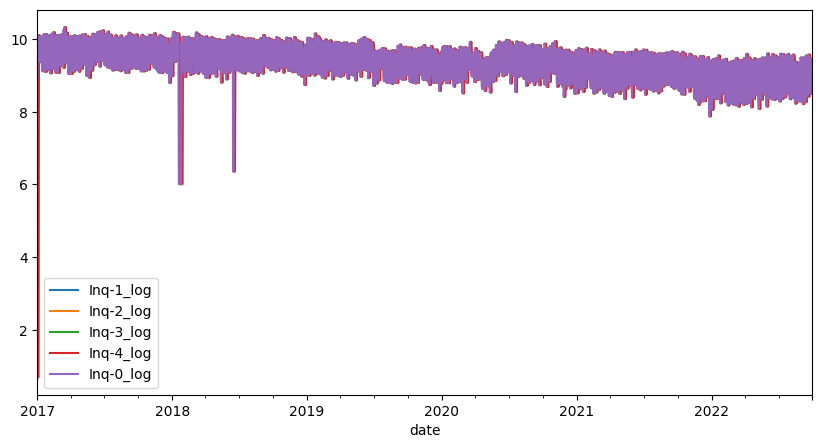

In [214]:
Daily_data_temp[['Inq-1_log','Inq-2_log','Inq-3_log','Inq-4_log','Inq-0_log']].plot()

In [215]:
adf_test(Daily_data_temp['Inq-0_log'])
adf_test(Daily_data_temp['Inq-1_log'])
adf_test(Daily_data_temp['Inq-2_log'])
adf_test(Daily_data_temp['Inq-3_log'])
adf_test(Daily_data_temp['Inq-4_log'])
adf_test(Daily_data_temp['Inq_mean_8_log'])

Results of Dickey-Fuller Test:
Non-Stationary
Stationary
Stationary

Test Statistic                   -3.376951
p-value                           0.011770
#Lags Used                       26.000000
Number of Observations Used    2072.000000
Critical Value (1%)              -3.433510
Critical Value (5%)              -2.862936
Critical Value (10%)             -2.567513
dtype: float64

Results of Dickey-Fuller Test:
Stationary
Stationary
Stationary

Test Statistic                   -3.492167
p-value                           0.008191
#Lags Used                       26.000000
Number of Observations Used    2072.000000
Critical Value (1%)              -3.433510
Critical Value (5%)              -2.862936
Critical Value (10%)             -2.567513
dtype: float64

Results of Dickey-Fuller Test:
Stationary
Stationary
Stationary

Test Statistic                   -3.594698
p-value                           0.005863
#Lags Used                       26.000000
Number of Observations Used    2072.00

In [216]:
kpss_test(Daily_data_temp['Inq-0_log'])
kpss_test(Daily_data_temp['Inq-1_log'])
kpss_test(Daily_data_temp['Inq-2_log'])
kpss_test(Daily_data_temp['Inq-3_log'])
kpss_test(Daily_data_temp['Inq-4_log'])
kpss_test(Daily_data_temp['Inq_mean_8_log'])

Results of KPSS Test:
Non-Stationary
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic            8.64841
p-value                   0.01000
#Lags Used               15.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64

Results of KPSS Test:
Non-Stationary
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic            8.523512
p-value                   0.010000
#Lags Used               14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Results of KPSS Test:
Non-Stationary
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic            7.859457
p-value                   0.010000
#Lags Used               13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       

Differencing

In [263]:
# Removing positive upward trend from Daily_data_temp['Inq-1']

#Daily_data_temp_check = pd.DataFrame()
# applying differencing to remove trend from total_cust
Daily_data_temp_check = Daily_data_temp
#[['Inq-1_log','Inq-2_log','Inq-3_log','Inq-4_log','Inq-0_log']]
#[['Inq-1_log_diff','Inq-2_log_diff','Inq-3_log_diff','Inq-4_log_diff','Inq-0_log_diff']]
Daily_data_temp_check['Inq-1_log_diff'] = Daily_data_temp_check['Inq-1_log'] - Daily_data_temp_check['Inq-1_log'].shift()
Daily_data_temp_check['Inq-2_log_diff'] = Daily_data_temp_check['Inq-2_log'] - Daily_data_temp_check['Inq-2_log'].shift()
Daily_data_temp_check['Inq-3_log_diff'] = Daily_data_temp_check['Inq-3_log'] - Daily_data_temp_check['Inq-3_log'].shift()
Daily_data_temp_check['Inq-4_log_diff'] = Daily_data_temp_check['Inq-4_log'] - Daily_data_temp_check['Inq-4_log'].shift()
Daily_data_temp_check['Inq-0_log_diff'] = Daily_data_temp_check['Inq-0_log'] - Daily_data_temp_check['Inq-0_log'].shift()
Daily_data_temp_check['Inq_mean_8_log_diff'] = Daily_data_temp_check['Inq_mean_8_log'] - Daily_data_temp_check['Inq_mean_8_log'].shift()

Daily_data_temp_check# = Daily_data_temp_check.iloc[1:,]

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,weekday,weekday_1,weekday_2,weekday_3,weekday_4,...,Inq-2_log,Inq-3_log,Inq-4_log,Inq-0_log,Inq-1_log_diff,Inq-2_log_diff,Inq-3_log_diff,Inq-4_log_diff,Inq-0_log_diff,Inq_mean_8_log_diff
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,7574.0,0,0,0,1,6,0,0,0,0,...,0.693147,0.693147,0.693147,8.932741,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,13189.0,0,0,0,1,0,0,0,0,0,...,0.693147,0.693147,0.693147,9.487290,8.239593,0.000000,0.000000,0.000000,0.554549,0.000000
2017-01-03,24678.0,0,0,0,1,1,1,0,0,0,...,8.932741,0.693147,0.693147,10.113748,0.554549,8.239593,0.000000,0.000000,0.626458,0.000000
2017-01-04,23380.0,0,0,0,1,2,0,1,0,0,...,9.487290,8.932741,0.693147,10.059722,0.626458,0.554549,8.239593,0.000000,-0.054027,0.000000
2017-01-05,22809.0,0,0,0,1,3,0,0,1,0,...,10.113748,9.487290,8.932741,10.034998,-0.054027,0.626458,0.554549,8.239593,-0.024724,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,13039.0,0,0,1,0,0,0,0,0,0,...,8.500250,9.284520,9.390576,9.475854,0.021930,-0.784269,-0.106057,-0.041466,0.953673,0.104279
2022-09-27,11598.0,0,0,1,0,1,1,0,0,0,...,8.522181,8.500250,9.284520,9.358760,0.953673,0.021930,-0.784269,-0.106057,-0.117093,-0.033149
2022-09-28,11886.0,0,0,1,0,2,0,1,0,0,...,9.475854,8.522181,8.500250,9.383285,-0.117093,0.953673,0.021930,-0.784269,0.024524,-0.018506


In [221]:
Daily_data_temp_check = Daily_data_temp_check.fillna(0)
adf_test(Daily_data_temp_check['Inq-0_log_diff'])
adf_test(Daily_data_temp_check['Inq-1_log_diff'])
adf_test(Daily_data_temp_check['Inq-2_log_diff'])
adf_test(Daily_data_temp_check['Inq-3_log_diff'])
adf_test(Daily_data_temp_check['Inq-4_log_diff'])
adf_test(Daily_data_temp_check['Inq_mean_8_log_diff'])

Results of Dickey-Fuller Test:
Stationary
Stationary
Stationary

Test Statistic                -1.778117e+01
p-value                        3.276621e-30
#Lags Used                     2.600000e+01
Number of Observations Used    2.072000e+03
Critical Value (1%)           -3.433510e+00
Critical Value (5%)           -2.862936e+00
Critical Value (10%)          -2.567513e+00
dtype: float64

Results of Dickey-Fuller Test:
Stationary
Stationary
Stationary

Test Statistic                -1.620932e+01
p-value                        4.001602e-29
#Lags Used                     2.600000e+01
Number of Observations Used    2.072000e+03
Critical Value (1%)           -3.433510e+00
Critical Value (5%)           -2.862936e+00
Critical Value (10%)          -2.567513e+00
dtype: float64

Results of Dickey-Fuller Test:
Stationary
Stationary
Stationary

Test Statistic                -1.604022e+01
p-value                        5.925188e-29
#Lags Used                     2.600000e+01
Number of Observations Us

In [222]:
kpss_test(Daily_data_temp_check['Inq-0_log_diff'])
kpss_test(Daily_data_temp_check['Inq-1_log_diff'])
kpss_test(Daily_data_temp_check['Inq-2_log_diff'])
kpss_test(Daily_data_temp_check['Inq-3_log_diff'])
kpss_test(Daily_data_temp_check['Inq-4_log_diff'])
kpss_test(Daily_data_temp_check['Inq_mean_8_log_diff'])

Results of KPSS Test:
Stationary
Stationary
Stationary
Stationary

Test Statistic            0.022423
p-value                   0.100000
#Lags Used               57.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Results of KPSS Test:
Stationary
Stationary
Stationary
Stationary

Test Statistic            0.274528
p-value                   0.100000
#Lags Used               67.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Results of KPSS Test:
Stationary
Stationary
Stationary
Stationary

Test Statistic            0.274062
p-value                   0.100000
#Lags Used               67.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Results of KPSS 

In [265]:
Daily_data_temp_check.describe()#.columns()

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,weekday,weekday_1,weekday_2,weekday_3,weekday_4,...,Inq-2_log,Inq-3_log,Inq-4_log,Inq-0_log,Inq-1_log_diff,Inq-2_log_diff,Inq-3_log_diff,Inq-4_log_diff,Inq-0_log_diff,Inq_mean_8_log_diff
count,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000,...,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000,2099.000000
mean,14240.924250,0.262982,0.262982,0.231062,0.242973,2.999047,0.142925,0.142925,0.142925,0.142925,...,9.448830,9.444690,9.440561,9.457054,0.004136,0.004140,0.004128,0.004184,0.000163,0.004056
std,5809.277724,0.440358,0.440358,0.421613,0.428981,2.000476,0.350080,0.350080,0.350080,0.350080,...,0.581677,0.612266,0.641370,0.514992,0.516176,0.516176,0.516176,0.516169,0.483838,0.204999
min,406.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.693147,0.693147,0.693147,6.011267,-4.006977,-4.006977,-4.006977,-4.006977,-4.006977,-0.633511
25%,9739.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,9.181632,9.181220,9.179261,9.184150,-0.144359,-0.144359,-0.144359,-0.144359,-0.144359,-0.019172
50%,13864.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,9.537195,9.537195,9.537195,9.537195,-0.061843,-0.061843,-0.061843,-0.061754,-0.061866,-0.007825
75%,19310.000000,1.000000,1.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,...,9.868482,9.868482,9.868482,9.868482,0.010123,0.010123,0.009810,0.009810,0.009810,0.006415
max,30619.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,10.329441,10.329441,10.329441,10.329441,8.239593,8.239593,8.239593,8.239593,3.915253,9.045060


## Feature Selection
Based on the EDA above, I will choose the following features

holiday: t0

weekdays: each day at t0

workingday: t0

season_spring: t0

season_summer: t0

season_fall: t0

season_winter: t0

inq: t-1, t-2, t-3, t-4

inq: rolling mean for 9 days

# Data Preparation

3.1. Dropping unnecessary columns
I am only going to remove any columns which I no longer need and split the dataframes into X and y.

In [268]:
final_df  = Daily_data_temp_check.drop(columns=['weekday', 'Inq-1', 'Inq-2',
       'Inq-3', 'Inq-4', 'Inq_mean_8', 'Inq_std_4', 'Inq_std_8',
       'Inq_mean_8_log', 'Inq-1_log', 'Inq-2_log', 'Inq-3_log', 'Inq-4_log',
       'Inq-0_log','Inq-0_log_diff'])
final_df.columns

Index(['Inquiries_NonStat', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'working_day', 'holiday', 'Inq-1_log_diff',
       'Inq-2_log_diff', 'Inq-3_log_diff', 'Inq-4_log_diff',
       'Inq_mean_8_log_diff'],
      dtype='object')

In [269]:
# assigning X and y
y = final_df['Inquiries_NonStat']
X = final_df.drop(columns=['Inquiries_NonStat'])

# Model

### Baseline model: naive univariate prediction
When using autoregression models, we're only focusing on the target variable and aim to predict this variable with it previous values.

In [271]:
# assigning X and y for the univariate naive prediction
y_naive = (final_df['Inquiries_NonStat'].copy())
X_naive = y_naive.copy()
X_naive = pd.DataFrame(data=X_naive, columns=['Inquiries_NonStat'])

# getting the start time
start_time = datetime.datetime.now()

# creating y_pred
y_pred = (X_naive.shift())[1:]
# adjusting length of the actual target values
y_naive = y_naive[1:]

# get final time
end_time = datetime.datetime.now()
print('Total running time of naive predictor:', (end_time - start_time).total_seconds())

# calculating the scores for the last value method
print('RMSE:', np.sqrt(mean_squared_error(y_naive, y_pred)))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_naive, y_pred)))
print('MAE:', mean_absolute_error(y_naive, y_pred))

Total running time of naive predictor: 0.000997
RMSE: 5492.707311136746
RMSLE: 0.4839121144660448
MAE: 3598.736415633937


### Models with Lazy Predict

In [272]:
final_df.head(2)

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,working_day,holiday,Inq-1_log_diff,Inq-2_log_diff,Inq-3_log_diff,Inq-4_log_diff,Inq_mean_8_log_diff
date,,,,,,,,,,,,,,,,,,
2017-01-01,7574.0,0,0,0,1,0,0,0,0,0,1,0.0,1.0,0.000000,0.0,0.0,0.0,0.0
2017-01-02,13189.0,0,0,0,1,0,0,0,0,0,0,0.0,1.0,8.239593,0.0,0.0,0.0,0.0


In [277]:
# Split the data into training, validation, and test sets
train_df = final_df[:int(len(final_df)*0.7)]                       # 70% train set
val_df = final_df[int(len(final_df)*0.7):int(len(final_df)*0.9)]   # 20% validation set
test_df = final_df[int(len(final_df)*0.9):]                        # 10% test set


In [284]:
log_final_df  = Daily_data_temp_check.drop(columns=['weekday', 'Inq-1', 'Inq-2',
       'Inq-3', 'Inq-4', 'Inq_mean_8', 'Inq_std_4', 'Inq_std_8',
       'Inq_mean_8_log', 'Inq-1_log', 'Inq-2_log', 'Inq-3_log', 'Inq-4_log',
       'Inq-0_log'])
log_final_df.columns

Index(['Inquiries_NonStat', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'working_day', 'holiday', 'Inq-1_log_diff',
       'Inq-2_log_diff', 'Inq-3_log_diff', 'Inq-4_log_diff', 'Inq-0_log_diff',
       'Inq_mean_8_log_diff'],
      dtype='object')

In [285]:
# assigning X and y
y = log_final_df['Inq-0_log_diff']
X = log_final_df.drop(columns=['Inquiries_NonStat','Inq-0_log_diff'])

# getting the start time
start_time = datetime.datetime.now()

X, y = shuffle(X, y, random_state=13)
X = X.astype(np.float32)
train_offset = int(X.shape[0] * 0.7)
val_offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:train_offset], y[:train_offset]
X_test, y_test = X[train_offset:val_offset], y[train_offset:val_offset]

reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

# get final time
end_time = datetime.datetime.now()
print('Total running time of naive predictor:', (end_time - start_time).total_seconds())

 21%|██▏       | 9/42 [00:00<00:03,  8.28it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 67%|██████▋   | 28/42 [00:03<00:02,  6.06it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


100%|██████████| 42/42 [01:34<00:00,  2.24s/it]

Total running time of naive predictor: 94.206776


In [286]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreeRegressor,0.83,0.84,0.21,0.01
GradientBoostingRegressor,0.83,0.83,0.21,0.22
RandomForestRegressor,0.79,0.80,0.23,0.82
ExtraTreesRegressor,0.78,0.79,0.24,0.52
NuSVR,0.78,0.79,0.24,0.28
BaggingRegressor,0.77,0.78,0.24,0.11
SVR,0.77,0.78,0.24,0.06
XGBRegressor,0.77,0.78,0.24,0.15
LGBMRegressor,0.77,0.78,0.24,0.11


In [301]:
# assigning X and y
y = log_final_df['Inq-0_log_diff']
X = log_final_df.drop(columns=['Inquiries_NonStat','Inq-0_log_diff'])

# getting the start time
start_time = datetime.datetime.now()

X, y = shuffle(X, y, random_state=13)
X = X.astype(np.float32)
train_offset = int(X.shape[0] * 0.7)
val_offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:train_offset], y[:train_offset]
X_val, y_val = X[train_offset:val_offset], y[train_offset:val_offset]
X_test, y_test = X[val_offset:], y[val_offset:]

reg = RandomForestRegressor(verbose=0)
models_rf = reg.fit(X_train,y_train)
#.fit(X_train, X_test, y_train, y_test)
#,
predictions_rf  = models_rf.predict(X_val)
# get final time
end_time = datetime.datetime.now()
print('Total running time of RandomForestRegressor:', (end_time - start_time).total_seconds())

Total running time of RandomForestRegressor: 0.827506


In [303]:
# calculating the scores for the last value method
print('Val RMSE:', np.sqrt(mean_squared_error(y_val, predictions_rf)))
#print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, predictions_rf)))
print('Val MAE:', mean_absolute_error(y_val, predictions_rf))

Val RMSE: 0.233934251900701
Val MAE: 0.07528931294902108


In [307]:
log_final_df


,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,working_day,holiday,Inq-1_log_diff,Inq-2_log_diff,Inq-3_log_diff,Inq-4_log_diff,Inq-0_log_diff,Inq_mean_8_log_diff
date,,,,,,,,,,,,,,,,,,,
2017-01-01,7574.00,0,0,0,1,0,0,0,0,0,1,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2017-01-02,13189.00,0,0,0,1,0,0,0,0,0,0,0.00,1.00,8.24,0.00,0.00,0.00,0.55,0.00
2017-01-03,24678.00,0,0,0,1,1,0,0,0,0,0,1.00,0.00,0.55,8.24,0.00,0.00,0.63,0.00
2017-01-04,23380.00,0,0,0,1,0,1,0,0,0,0,1.00,0.00,0.63,0.55,8.24,0.00,-0.05,0.00
2017-01-05,22809.00,0,0,0,1,0,0,1,0,0,0,1.00,0.00,-0.05,0.63,0.55,8.24,-0.02,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,13039.00,0,0,1,0,0,0,0,0,0,0,1.00,0.00,0.02,-0.78,-0.11,-0.04,0.95,0.10
2022-09-27,11598.00,0,0,1,0,1,0,0,0,0,0,1.00,0.00,0.95,0.02,-0.78,-0.11,-0.12,-0.03
2022-09-28,11886.00,0,0,1,0,0,1,0,0,0,0,1.00,0.00,-0.12,0.95,0.02,-0.78,0.02,-0.02


### Naive Random Regressor

In [314]:
# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.3, shuffle = True, random_state = 0)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.15, random_state= 0) # 0.15 x 0.7 = 0.1

In [315]:
naive_rf_model=RandomForestRegressor(random_state=0)
naive_rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [325]:
from sklearn.metrics import log_loss, roc_auc_score, roc_curve

train_y_hat = naive_rf_model.predict(X_train)
# calculating the scores for the last value method
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, train_y_hat)))
#print('RMSLE:', np.sqrt(mean_squared_log_error(y_train, train_y_hat)))
print('Train MAE:', mean_absolute_error(y_train, train_y_hat))

Train RMSE: 0.0729523447780472
Train MAE: 0.028811605430697638


In [327]:
val_y_hat=naive_rf_model.predict(X_val)
# calculating the scores for the last value method
print('val RMSE:', np.sqrt(mean_squared_error(y_val, val_y_hat)))
#print('RMSLE:', np.sqrt(mean_squared_log_error(y_train, train_y_hat)))
print('val MAE:', mean_absolute_error(y_val, val_y_hat))

val RMSE: 0.10181296255757988
val MAE: 0.05806362336860685


In [326]:
test_y_hat=naive_rf_model.predict(X_test)
# calculating the scores for the last value method
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, test_y_hat)))
#print('RMSLE:', np.sqrt(mean_squared_log_error(y_train, train_y_hat)))
print('Test MAE:', mean_absolute_error(y_test, test_y_hat))

Test RMSE: 0.24782643946646818
Test MAE: 0.08377291676624317


Walk-forward Validation

In [310]:
from sklearn.model_selection import TimeSeriesSplit

# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
tscv
tscv.split(log_final_df)

<generator object TimeSeriesSplit.split at 0x0000022B66BAD230>

In [311]:
# Initialize models
random_search_model = RandomForestRegressor(random_state=0)
grid_search_model   = RandomForestRegressor(random_state=0)

In [353]:
# Set up the grid to pick hyperparameters from:
param_dist = {"n_estimators": [10, 100, 500],
              "max_depth": [3, None],
              "min_samples_split": randint(2, 10),
              "min_samples_leaf": randint(1, 10),
              "bootstrap": [True, False]}

In [354]:
# Create the randomized search object
random_search = RandomizedSearchCV(random_search_model, param_distributions=param_dist, 
                                   n_iter=100, cv=tscv, 
                                   scoring="neg_mean_squared_error", 
                                   random_state=0)

In [355]:
# Fit the model to the data
y = log_final_df['Inq-0_log_diff']
X = log_final_df.drop(columns=['Inquiries_NonStat','Inq-0_log_diff'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.3, shuffle = True, random_state = 0)


# Fit the randomized search on the data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print(best_params)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


In [356]:
# Get the best model
best_model = random_search.best_estimator_
print(best_model)

RandomForestRegressor(min_samples_split=5, n_estimators=500, random_state=0)


In [357]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr = RandomForestRegressor(n_estimators=random_search.best_params_['n_estimators'],
                                  max_depth=random_search.best_params_['max_depth'],
                                  min_samples_split=random_search.best_params_['min_samples_split'],
                                  min_samples_leaf=random_search.best_params_['min_samples_leaf'],
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the test set
y_train_pred = best_rfr.predict(X_train)

# calculate the mean squared error of the predictions
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("Train MAE: ", train_mae)
print('Train RMSE:', train_rmse)

# use the final Random Forest Regressor model to make predictions on the test set
y_test_pred = best_rfr.predict(X_test)

# calculate the mean squared error of the predictions
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test MAE: ", test_mae)
print('Test RMSE:', test_rmse)


Train MAE:  0.028908284982848344
Train RMSE: 0.0735758672688365
Test MAE:  0.070974178741163
Test RMSE: 0.250805062025334


<AxesSubplot: xlabel='date'>

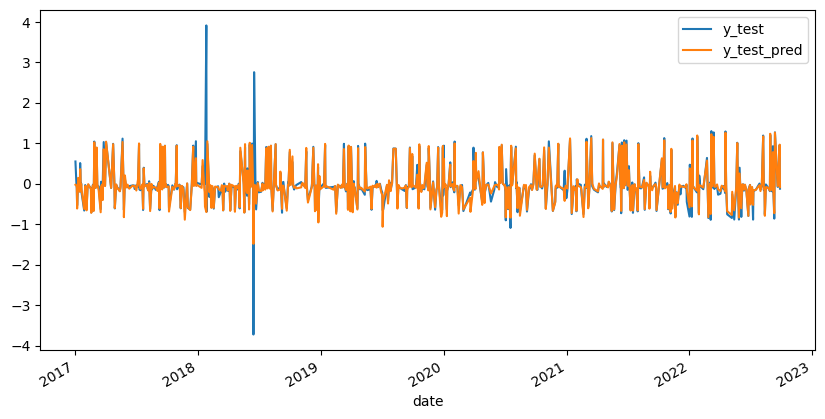

In [362]:
predictions_rf = pd.DataFrame()
predictions_rf['y_test'] = y_test
predictions_rf['y_test_pred'] = y_test_pred
predictions_rf.plot()

<AxesSubplot: xlabel='date'>

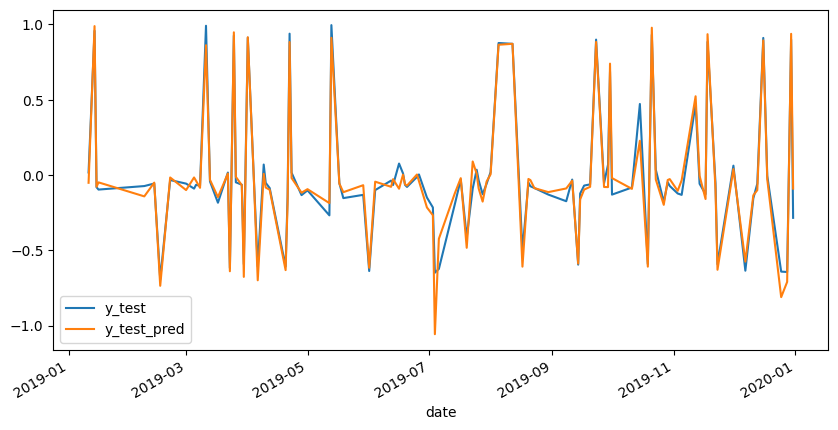

In [368]:
predictions_rf[predictions_rf.index.year == 2019].plot()

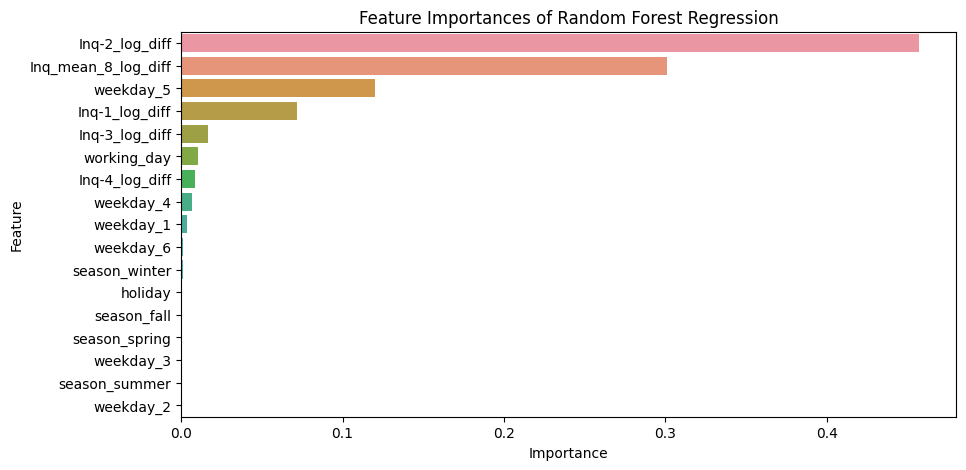

In [371]:
# Access the feature importances
importances = best_rfr.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [372]:
log_final_df

,Inquiries_NonStat,season_spring,season_summer,season_fall,season_winter,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,working_day,holiday,Inq-1_log_diff,Inq-2_log_diff,Inq-3_log_diff,Inq-4_log_diff,Inq-0_log_diff,Inq_mean_8_log_diff
date,,,,,,,,,,,,,,,,,,,
2017-01-01,7574.00,0,0,0,1,0,0,0,0,0,1,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2017-01-02,13189.00,0,0,0,1,0,0,0,0,0,0,0.00,1.00,8.24,0.00,0.00,0.00,0.55,0.00
2017-01-03,24678.00,0,0,0,1,1,0,0,0,0,0,1.00,0.00,0.55,8.24,0.00,0.00,0.63,0.00
2017-01-04,23380.00,0,0,0,1,0,1,0,0,0,0,1.00,0.00,0.63,0.55,8.24,0.00,-0.05,0.00
2017-01-05,22809.00,0,0,0,1,0,0,1,0,0,0,1.00,0.00,-0.05,0.63,0.55,8.24,-0.02,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,13039.00,0,0,1,0,0,0,0,0,0,0,1.00,0.00,0.02,-0.78,-0.11,-0.04,0.95,0.10
2022-09-27,11598.00,0,0,1,0,1,0,0,0,0,0,1.00,0.00,0.95,0.02,-0.78,-0.11,-0.12,-0.03
2022-09-28,11886.00,0,0,1,0,0,1,0,0,0,0,1.00,0.00,-0.12,0.95,0.02,-0.78,0.02,-0.02


### Saving & loading model

In [373]:
import joblib

filename = "C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/03-models/RF.joblib"
joblib.dump(best_rfr, filename)

['C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/03-models/RF.joblib']

In [375]:
best_rfr = joblib.load(filename)
best_rfr

RandomForestRegressor(min_samples_split=5, n_estimators=500, random_state=0)